In [1]:
# HIDDEN
import matplotlib
#matplotlib.use('Agg')
path_data = '../../../data/'
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import scipy.stats as stats
plt.style.use('fivethirtyeight')

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# HIDDEN

def standard_units(x):
    return (x - np.mean(x))/np.std(x)

In [3]:
# HIDDEN

# HIDDEN

def distance(pt1, pt2):
    return np.sqrt(np.sum((pt1 - pt2)**2))

def all_dists(training, p):
    attributes = training.drop('Class')
    def dist_point_row(row):
        return distance(np.array(row), p)
    return attributes.apply(dist_point_row)

def table_with_distances(training, p):
    return training.with_column('Distance', all_dists(training, p))

def closest(training, p, k):
    with_dists = table_with_distances(training, p)
    sorted_by_dist = with_dists.sort('Distance')
    topk = sorted_by_dist.take(np.arange(k))
    return topk

def majority(topkclasses):
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, p, k):
    closestk = closest(training, p, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

In [4]:
# HIDDEN

def classify_grid(training, test, k):
    c = make_array()
    for i in range(test.num_rows):
        # Run the classifier on the ith patient in the test set
        c = np.append(c, classify(training, make_array(test.row(i)), k))   
    return c

In [5]:
# HIDDEN 
ckd = Table.read_table(path_data + 'ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd = Table().with_columns(
    'Hemoglobin', standard_units(ckd.column('Hemoglobin')),
    'Glucose', standard_units(ckd.column('Glucose')),
    'White Blood Cell Count', standard_units(ckd.column('White Blood Cell Count')),
    'Class', ckd.column('Class')
)
color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
ckd = ckd.join('Class', color_table)

### Training and Testing ###
How good is our nearest neighbor classifier? To answer this we'll need to find out how frequently our classifications are correct. If a patient has chronic kidney disease, how likely is our classifier to pick that up?

If the patient is in our training set, we can find out immediately. We already know what class the patient is in. So we can just compare our prediction and the patient's true class.

But the point of the classifier is to make predictions for *new* patients not in our training set. We don't know what class these patients are in but we can make a prediction based on our classifier. How to find out whether the prediction is correct?

One way is to wait for further medical tests on the patient and then check whether or not our prediction agrees with the test results. With that approach, by the time we can say how likely our prediction is to be accurate, it is no longer useful for helping the patient.

Instead, we will try our classifier on some patients whose true classes are known.  Then, we will compute the proportion of the time our classifier was correct.  This proportion will serve as an estimate of the proportion of all new patients whose class our classifier will accurately predict.  This is called *testing*.

### Overly Optimistic "Testing" ###
The training set offers a very tempting set of patients on whom to test out our classifier, because we know the class of each patient in the training set.

But let's be careful ... there will be pitfalls ahead if we take this path. An example will show us why.

Suppose we use a 1-nearest neighbor classifier to predict whether a patient has chronic kidney disease, based on glucose and white blood cell count.

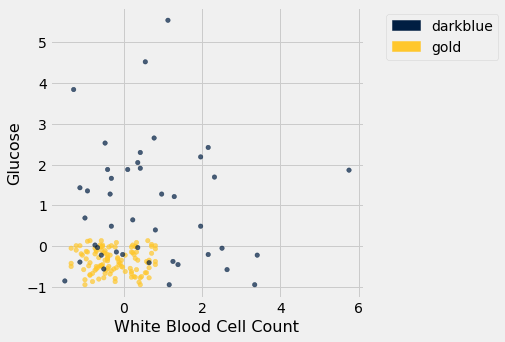

In [6]:
ckd.scatter('White Blood Cell Count', 'Glucose', colors='Color')

Earlier, we said that we expect to get some classifications wrong, because there's some intermingling of blue and gold points in the lower-left.

But what about the points in the training set, that is, the points already on the scatter? Will we ever mis-classify them?

The answer is no. Remember that 1-nearest neighbor classification looks for the point *in the training set* that is nearest to the point being classified. Well, if the point being classified is already in the training set, then its nearest neighbor in the training set is itself! And therefore it will be classified as its own color, which will be correct because each point in the training set is already correctly colored.

In other words, **if we use our training set to "test" our 1-nearest neighbor classifier, the classifier will pass the test 100% of the time.**

Mission accomplished. What a great classifier! 

No, not so much. A new point in the lower-left might easily be mis-classified, as we noted earlier. "100% accuracy" was a nice dream while it lasted.

The lesson of this example is *not* to use the training set to test a classifier that is based on it.

### Generating a Test Set ###
In earlier chapters, we saw that random sampling could be used to estimate the proportion of individuals in a population that met some criterion.  Unfortunately, we have just seen that the training set is not like a random sample from the population of all patients, in one important respect: Our classifier guesses correctly for a higher proportion of individuals in the training set than it does for individuals in the population.

When we computed confidence intervals for numerical parameters, we wanted to have many new random samples from a population, but we only had access to a single sample.  We solved that problem by taking bootstrap resamples from our sample.

We will use an analogous idea to test our classifier. We will *create two samples out of the original training set*, use one of the samples as our training set, and *the other one for testing*. 

So we will have three groups of individuals:
- a training set on which we can do any amount of exploration to build our classifier;
- a separate testing set on which to try out our classifier and see what fraction of times it classifies correctly;
- the underlying population of individuals for whom we don't know the true classes; the hope is that our classifier will succeed about as well for these individuals as it did for our testing set.

How to generate the training and testing sets? You've guessed it – we'll select at random.

There are 158 individuals in `ckd`. Let's use a random half of them for training and the other half for testing. To do this, we'll shuffle all the rows, take the first 79 as the training set, and the remaining 79 for testing.

In [7]:
shuffled_ckd = ckd.sample(with_replacement=False)
training = shuffled_ckd.take(np.arange(79))
testing = shuffled_ckd.take(np.arange(79, 158))

Now let's construct our classifier based on the points in the training sample:

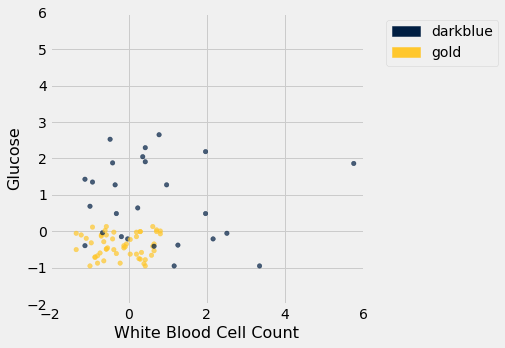

In [8]:
training.scatter('White Blood Cell Count', 'Glucose', colors='Color')
plt.xlim(-2, 6)
plt.ylim(-2, 6);

We get the following classification regions and decision boundary:

In [9]:
# HIDDEN

x_array = make_array()
y_array = make_array()
for x in np.arange(-2, 6.1, 0.25):
    for y in np.arange(-2, 6.1, 0.25):
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)
        
test_grid = Table().with_columns(
    'Glucose', x_array,
    'White Blood Cell Count', y_array
)

In [10]:
# HIDDEN

c = classify_grid(training.drop('Hemoglobin', 'Color'), test_grid, 1)

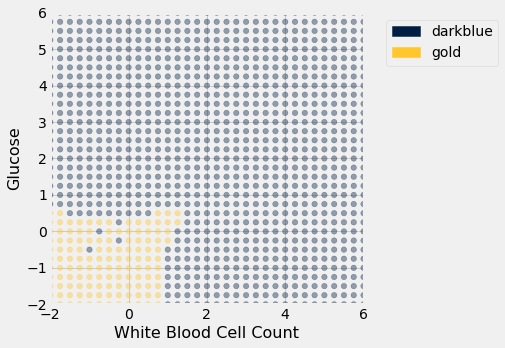

In [11]:
# HIDDEN

test_grid = test_grid.with_column('Class', c).join('Class', color_table)
test_grid.scatter('White Blood Cell Count', 'Glucose', colors='Color', alpha=0.4, s=30)

plt.xlim(-2, 6)
plt.ylim(-2, 6);

Place the *test* data on this graph and you can see at once that while the classifier got almost all the points right, there are some mistakes.  For example, some blue points of the test set fall in the gold region of the classifier.

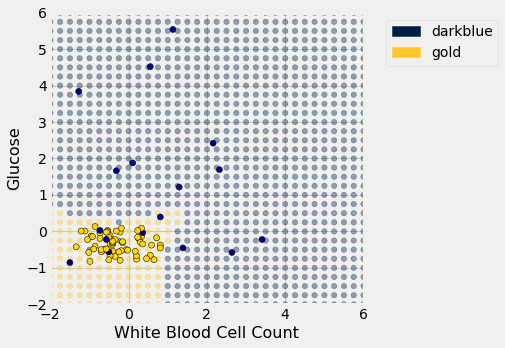

In [12]:
# HIDDEN

test_grid = test_grid.with_column('Class', c).join('Class', color_table)
test_grid.scatter('White Blood Cell Count', 'Glucose', colors='Color', alpha=0.4, s=30)

plt.scatter(testing.column('White Blood Cell Count'), testing.column('Glucose'), c=testing.column('Color'), edgecolor='k')

plt.xlim(-2, 6)
plt.ylim(-2, 6);

Some errors notwithstanding, it looks like the classifier does fairly well on the test set. Assuming that the original sample was drawn randomly from the underlying population, the hope is that the classifier will perform with similar accuracy on the overall population, since the test set was chosen randomly from the original sample.